In [1]:
# LSTM Autoencoder를 이용한 이상 온도 탐지
from torch.utils.data import DataLoader
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

from myProcessData import myProcessData
from myTimedistributed import TimeDistributed

# 데이터 준비
# temperature.csv 파일에서 데이터 불러오기
all_data = []
data = pd.read_csv('csv/pjh_temperature.csv')
data = data['temperature'].values
data = np.array(data)
data = data[:2000]
all_data.append(data)

data = pd.read_csv('csv/jdk_temperature.csv')
data = data['temperature'].values
data = np.array(data)
data = data[:2000]
all_data.append(data)


data = pd.read_csv('csv/pjh_temperature2.csv')
data = data['temperature'].values
data = np.array(data)
data = data[:2000]
all_data.append(data)

data = pd.read_csv('csv/bsb_temperature.csv')
data = data['temperature'].values
data = np.array(data)
data = data[:2000]
all_data.append(data)

# # 데이터 전처리 -----------------------------------------------
# train_dataset, train_dataloader, test_subset_dataset = myProcessData(all_data[0], sequence_length)

Text(0.5, 1.0, 'Temperature over Time')

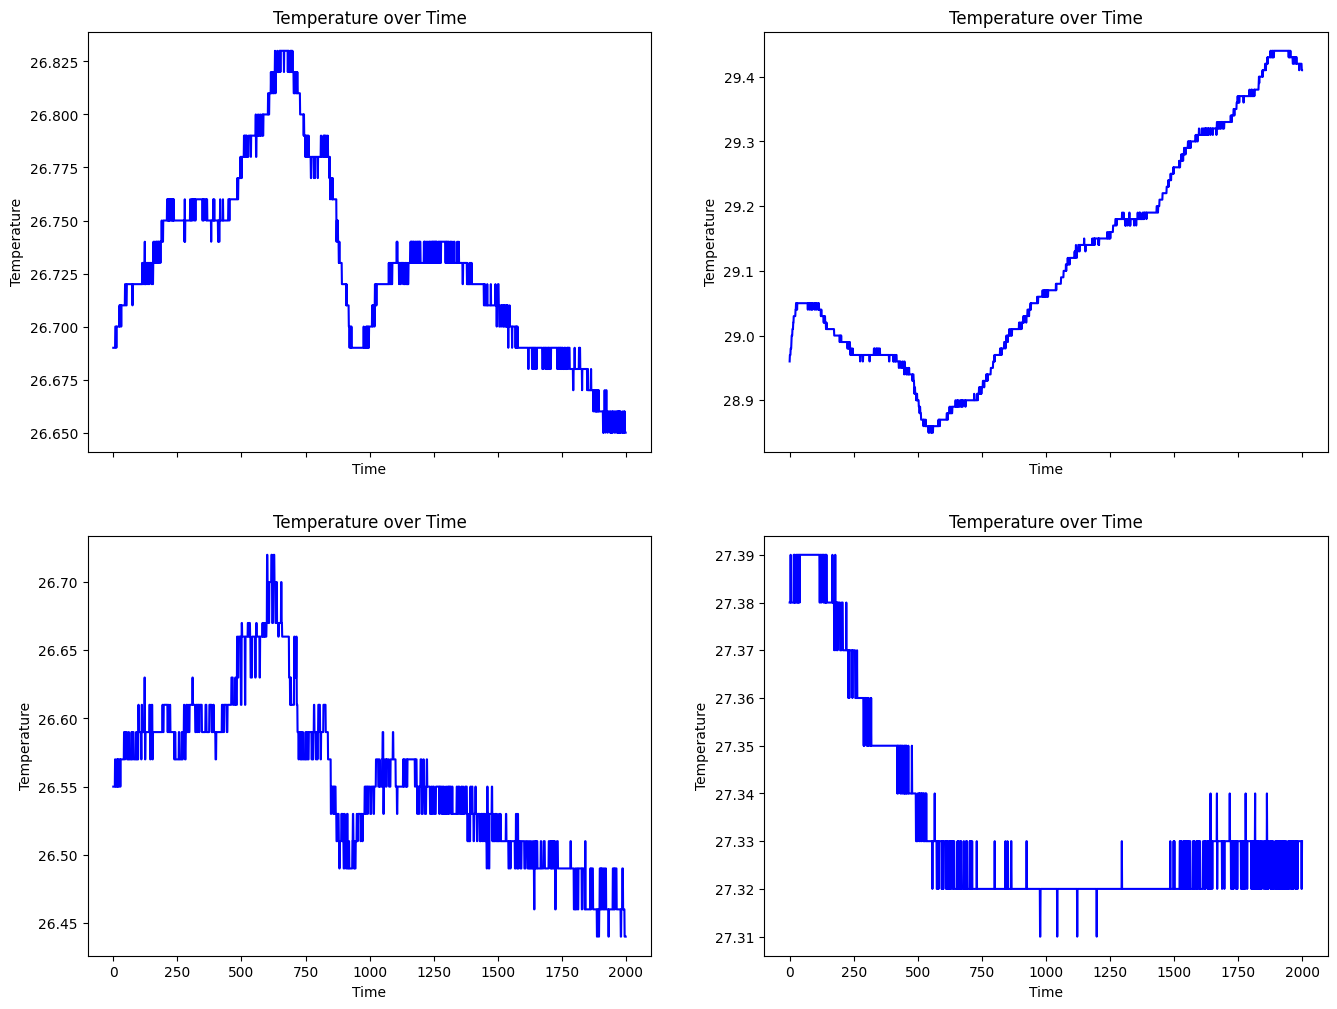

In [2]:
fig, axes = plt.subplots(2, 2, figsize=(16, 12), sharex=True)
axes[0, 0].plot(range(len(all_data[0])), all_data[0], 'b', label="Fold 1")
axes[0, 0].set_xlabel('Time')
axes[0, 0].set_ylabel('Temperature')
axes[0, 0].set_title('Temperature over Time')

axes[0, 1].plot(range(len(all_data[1])), all_data[1], 'b', label="Fold 2")
axes[0, 1].set_xlabel('Time')
axes[0, 1].set_ylabel('Temperature')
axes[0, 1].set_title('Temperature over Time')

axes[1, 0].plot(range(len(all_data[2])), all_data[2], 'b', label="Fold 1")
axes[1, 0].set_xlabel('Time')
axes[1, 0].set_ylabel('Temperature')
axes[1, 0].set_title('Temperature over Time')

axes[1, 1].plot(range(len(all_data[3])), all_data[3], 'b', label="Fold 2")
axes[1, 1].set_xlabel('Time')
axes[1, 1].set_ylabel('Temperature')
axes[1, 1].set_title('Temperature over Time')

In [3]:
# 모델 정의 및 학습 --------------------------------------
# 모델 구성
class Encoder(nn.Module):
    def __init__(self, input_size, hidden_size, sequence_length, batch_size):
        super(Encoder, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.sequence_length = sequence_length
        self.batch_size = batch_size
        self.encoder1 = nn.LSTM(input_size=input_size, hidden_size=hidden_size*2, batch_first=True)
        self.encoder2 = nn.LSTM(input_size=hidden_size*2, hidden_size=hidden_size, batch_first=True)

    def forward(self, x):
        encoded_output1, _ = self.encoder1(x)   # (16, 10, 128)
        _, hidden_state = self.encoder2(encoded_output1) # (16, 10, 64), (1, 16, 64)
        expanded_tensor = hidden_state[0].reshape(self.batch_size, 1, self.hidden_size) # (16, 1, 64)
        reshaped_tensor = expanded_tensor.expand(-1, self.sequence_length, -1)   # (16, 10, 64)
        # expanded_tensor = hidden_state[0].reshape(self.batch_size, self.sequence_length, self.hidden_size)
        return reshaped_tensor


class Decoder(nn.Module):
    def __init__(self, input_size, hidden_size, sequence_length):
        super(Decoder, self).__init__()
        self.decoder1 = nn.LSTM(input_size=hidden_size, hidden_size=hidden_size, batch_first=True)
        self.decoder2 = nn.LSTM(input_size=hidden_size, hidden_size=128, batch_first=True)
        self.timedistributed = TimeDistributed(nn.Linear(hidden_size*2, input_size))
    
    def forward(self, x):
        decoded_output1, _ = self.decoder1(x)   # (3, 10, 64)
        decoded_output2, _ = self.decoder2(decoded_output1) # (3, 10, 128)
        distributer_output = self.timedistributed(decoded_output2)  # (3, 10, 2)
        return distributer_output


class LSTM_Autoencoder(nn.Module):
    def __init__(self, input_size, hidden_size, sequence_length, batch_size):
        super(LSTM_Autoencoder, self).__init__()
        self.encoder = Encoder(
            input_size = input_size,
            hidden_size= hidden_size,
            sequence_length= sequence_length,
            batch_size=batch_size
        )
        self.decoder = Decoder(
            input_size = input_size,
            hidden_size= hidden_size,
            sequence_length= sequence_length
        )

    def forward(self, x):
        encoded_output = self.encoder(x)
        decoded_output = self.decoder(encoded_output)

        return decoded_output

sequence_length = 10  # 시퀀스 길이 설정
input_size = 1
hidden_size = 32
batch_size = 32
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model = LSTM_Autoencoder(input_size, hidden_size, sequence_length, batch_size).to(device)
# 손실 함수 정의
loss_function = nn.MSELoss()
# 옵티마이저 설정
optimizer = optim.Adam(model.parameters(), lr=0.001)

# K-fold Cross Validation
k = 4  # Number of folds
fold_losses = []
test_losses = []  # List to store the test losses
result_fold_loss = []
# K-fold data splitting
for i in range(k):
    print(f"Fold {i+1}")
    train_subset_dataloader, test_subset_dataloader = myProcessData(all_data[i], sequence_length, input_size, batch_size)
    # ------------------------------------------------------------

    # 모델 초기화
    # model = LSTM_Autoencoder(input_size, hidden_size, num_layers)
    model = LSTM_Autoencoder(input_size, hidden_size, sequence_length, batch_size).to(device)
    loss_function = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    
    # 학습
    fold_loss = []
    num_epochs = 100  # 학습 횟수 설정
    for epoch in range(num_epochs):
        print(f"epochs: {epoch}")
        for data in train_subset_dataloader:
            optimizer.zero_grad()
            data = data.to(device)
            outputs = model(data)
            loss = loss_function(outputs.reshape(-1, input_size), data.reshape(-1, input_size))
            loss.backward()
            optimizer.step()
        fold_loss.append(loss.item())

    test_subset_loss = []
    # 테스트 데이터에 대한 재구성 오차 계산
    with torch.no_grad():
        for data in test_subset_dataloader:
            data = data.to(device)
            test_subset_outputs = model(data)
            test_subset_loss.append(loss_function(test_subset_outputs, data))

    # Append the average test loss to test_losses list
    print(f"Loss after training: {fold_loss[-1]}")
    print(f"Fold {i+1} Test loss: {test_subset_loss}")
    print('===========================================================')
    # 수정. 학습결과인 MSE를 기록한다.
    fold_losses.append(fold_loss)
    # 각 fold 별 최종 학습 결과인 MSE를 기록
    result_fold_loss.append(fold_loss[-1])

    # 이건 미리 나눴던 테스트 데이터들을 이용해 예측한 결과인 MSE
    test_losses.append(test_subset_loss)

Fold 1
1591
191
epochs: 0
epochs: 1
epochs: 2
epochs: 3
epochs: 4
epochs: 5
epochs: 6
epochs: 7
epochs: 8
epochs: 9
epochs: 10
epochs: 11
epochs: 12
epochs: 13
epochs: 14
epochs: 15
epochs: 16
epochs: 17
epochs: 18
epochs: 19
epochs: 20
epochs: 21
epochs: 22
epochs: 23
epochs: 24
epochs: 25
epochs: 26
epochs: 27
epochs: 28
epochs: 29
epochs: 30
epochs: 31
epochs: 32
epochs: 33
epochs: 34
epochs: 35
epochs: 36
epochs: 37
epochs: 38
epochs: 39
epochs: 40
epochs: 41
epochs: 42
epochs: 43
epochs: 44
epochs: 45
epochs: 46
epochs: 47
epochs: 48
epochs: 49
epochs: 50
epochs: 51
epochs: 52
epochs: 53
epochs: 54
epochs: 55
epochs: 56
epochs: 57
epochs: 58
epochs: 59
epochs: 60
epochs: 61
epochs: 62
epochs: 63
epochs: 64
epochs: 65
epochs: 66
epochs: 67
epochs: 68
epochs: 69
epochs: 70
epochs: 71
epochs: 72
epochs: 73
epochs: 74
epochs: 75
epochs: 76
epochs: 77
epochs: 78
epochs: 79
epochs: 80
epochs: 81
epochs: 82
epochs: 83
epochs: 84
epochs: 85
epochs: 86
epochs: 87
epochs: 88
epochs: 89
epoc

[[tensor(0.0090, device='cuda:0'), tensor(0.0074, device='cuda:0'), tensor(0.0081, device='cuda:0'), tensor(0.0088, device='cuda:0'), tensor(0.0064, device='cuda:0')], [tensor(0.0027, device='cuda:0'), tensor(0.0029, device='cuda:0'), tensor(0.0027, device='cuda:0'), tensor(0.0025, device='cuda:0'), tensor(0.0037, device='cuda:0')], [tensor(0.0096, device='cuda:0'), tensor(0.0103, device='cuda:0'), tensor(0.0102, device='cuda:0'), tensor(0.0111, device='cuda:0'), tensor(0.0125, device='cuda:0')], [tensor(0.0512, device='cuda:0'), tensor(0.0450, device='cuda:0'), tensor(0.0417, device='cuda:0'), tensor(0.0477, device='cuda:0'), tensor(0.0412, device='cuda:0')]]
[0.00904492 0.00735338 0.0081081  0.00877351 0.00638273 0.00269606
 0.00285931 0.00273967 0.00245812 0.00368268 0.00963364 0.01032719
 0.01020836 0.01106714 0.01251941 0.05122489 0.04501153 0.04174988
 0.04766604 0.04119325]


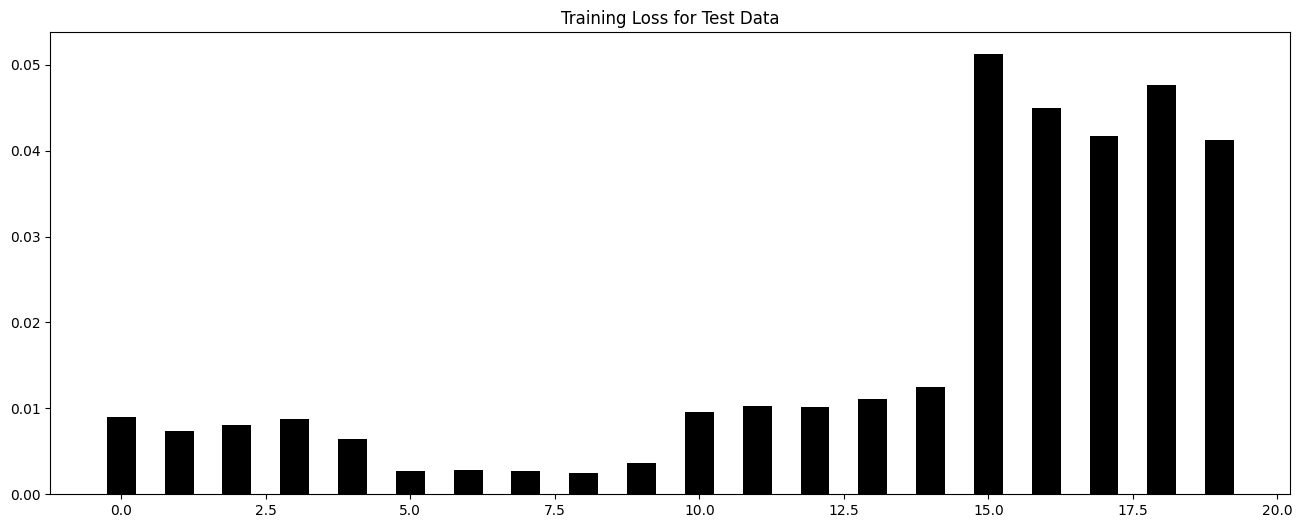

In [4]:
print(test_losses)
test_losses_cpu = []
for sublist in test_losses:
    cpu_sublist = [tensor.cpu() for tensor in sublist]
    test_losses_cpu.append(cpu_sublist)
test_losses_cpu = [[tensor.item() for tensor in sublist] for sublist in test_losses_cpu]
test_losses_cpu = np.reshape(test_losses_cpu, -1)
print(test_losses_cpu)
fig, ax = plt.subplots(figsize=(16, 6))
ax.bar(range(len(test_losses_cpu)), test_losses_cpu, width=0.5, align='center', color='k')
plt.title('Training Loss for Test Data')
plt.show()

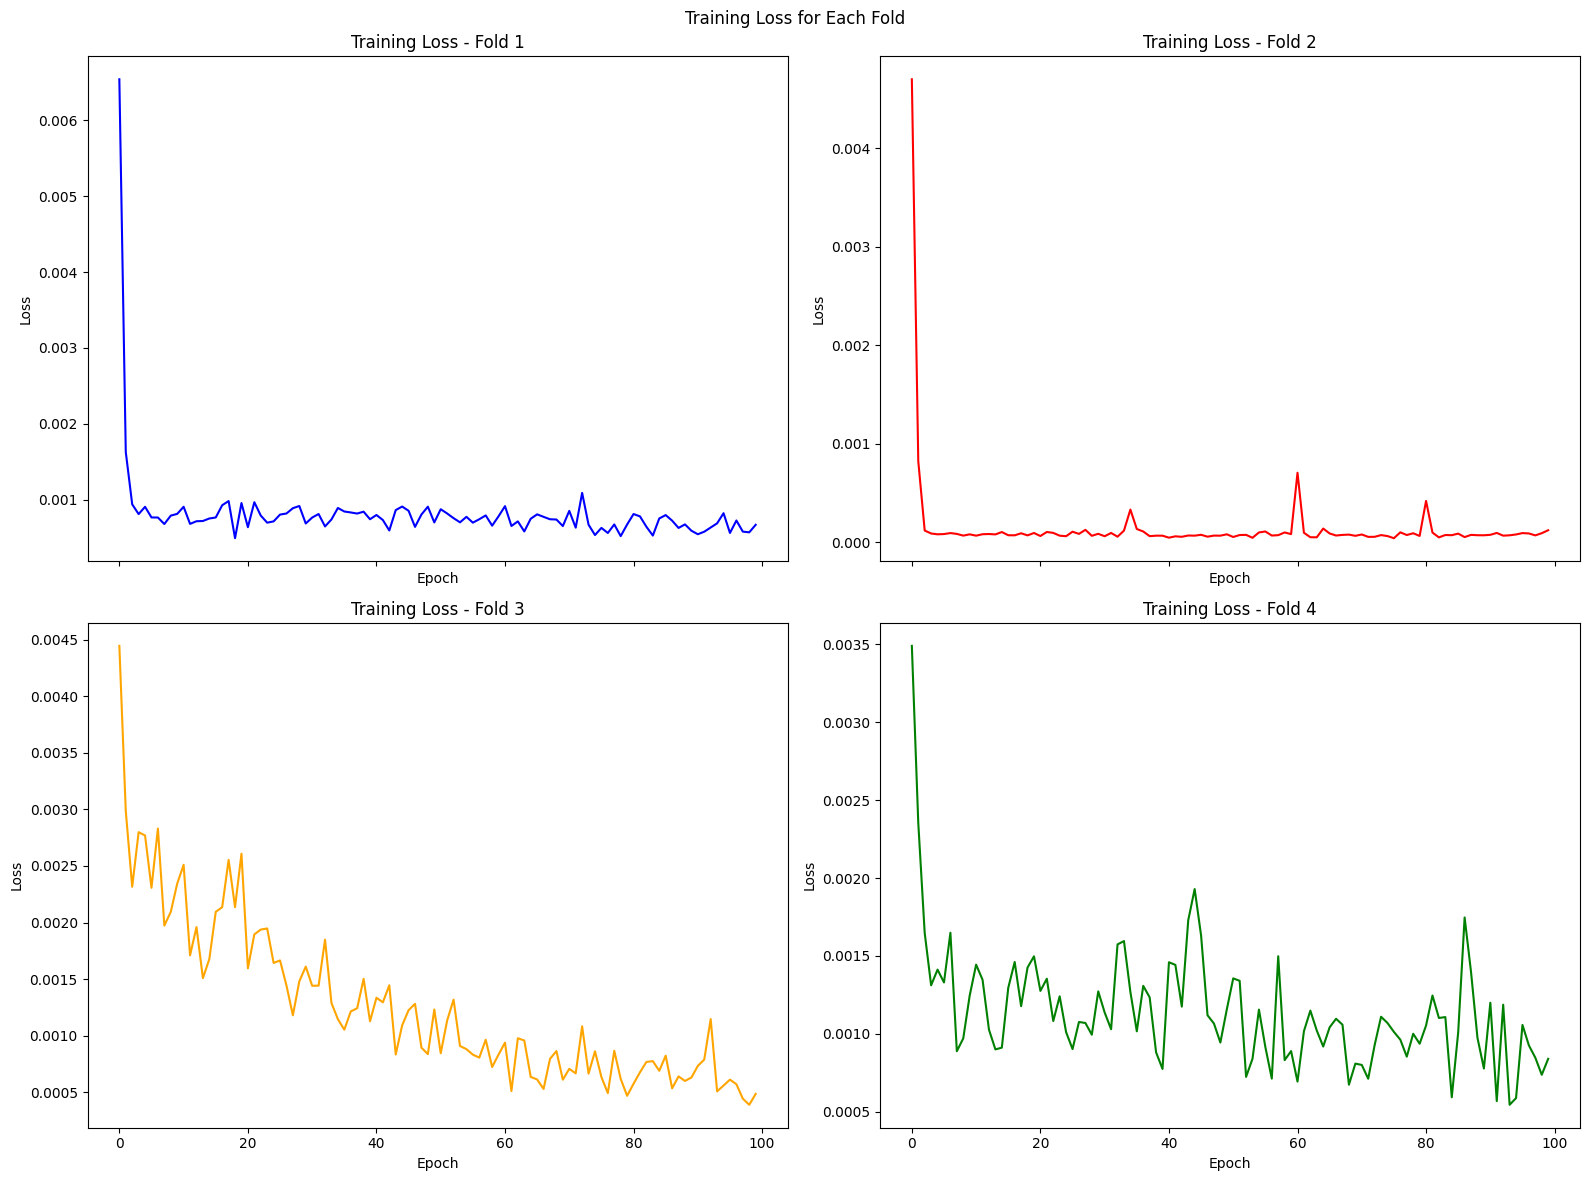

In [5]:
# # 최소값과 인접한 값을 클러스터링
# # K-means 알고리즘 적용
# print(f"Training result: {result_fold_loss}")
# print(f"Each test result: {test_losses}")
# data = np.array(test_losses).reshape(-1, 1)
# k = 2  # 클러스터 개수
# kmeans = KMeans(n_clusters=k, random_state=0, n_init=10)
# kmeans.fit(data)

# # 클러스터링 결과 확인
# labels = kmeans.labels_
# min_value = np.min(test_losses)
# min_label = labels[data.flatten() == min_value]
# cluster_data = data[labels == min_label]
# # Calculate the mean threshold
# mean_threshold = np.mean(cluster_data)
# print(f"Mean threshold: {mean_threshold:.4f}")

# # 테스트 데이터에 대한 이상 감지
# anomaly_indices = torch.where(test_subset_loss > mean_threshold)[0]
# anomaly_data = test_data[anomaly_indices]
# # 이상 감지 결과 출력
# print(f'Anomaly data indices: {anomaly_indices.tolist()}')
# anomaly_data = (anomaly_data * std) + mean
# print(f"Anomaly data: {anomaly_data}")


# Plotting the losses for each fold
fig, axes = plt.subplots(2, 2, figsize=(16, 12), sharex=True)

axes[0, 0].plot(range(len(fold_losses[0])), fold_losses[0], 'b', label="Fold 1")
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Loss')
axes[0, 0].set_title('Training Loss - Fold 1')

axes[0, 1].plot(range(len(fold_losses[1])), fold_losses[1], 'r', label="Fold 2")
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('Loss')
axes[0, 1].set_title('Training Loss - Fold 2')

axes[1, 0].plot(range(len(fold_losses[2])), fold_losses[2], 'orange', label="Fold 3")
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('Loss')
axes[1, 0].set_title('Training Loss - Fold 3')

axes[1, 1].plot(range(len(fold_losses[3])), fold_losses[3], 'g', label="Fold 4")
axes[1, 1].set_xlabel('Epoch')
axes[1, 1].set_ylabel('Loss')
axes[1, 1].set_title('Training Loss - Fold 4')

plt.suptitle('Training Loss for Each Fold')
plt.tight_layout()
plt.show()


In [6]:
# 비정상 데이터 생성 =======================================
# 데이터 파일 불러오기
data = pd.read_csv('csv/bsb_temperature.csv')
abnormal_data = data['temperature'].values
abnormal_data = abnormal_data[:2000]

# # Noise case 1 : 정현파 노이즈
# X=np.linspace(0,4*np.pi,len(abnormal_data))
# sin_wave=np.sin(X)
# abnormal_data += -sin_wave

# Noise case 2 : 특정 구간 랜덤 노이즈
start_index = 750
end_index = 850
interval_length = end_index - start_index
noise = np.random.uniform(-0.05, 0.05, interval_length)
abnormal_data[start_index:end_index] += noise

start_index = 1350
end_index = 1450
interval_length = end_index - start_index
noise = np.random.uniform(-0.05, 0.05, interval_length)
abnormal_data[start_index:end_index] += noise

# Normalization X -> Standardization
abnormal_mean = np.mean(abnormal_data)
abnormal_max = np.max(abnormal_data)
abnormal_min = np.min(abnormal_data)
processed_data = (abnormal_data - abnormal_mean) / (abnormal_max - abnormal_min)

# 데이터 시계열 시퀀스로 변환 X

# 3D로 변환
abnormal_dataset = np.reshape(processed_data, (-1, sequence_length, input_size))
# PyTorch 데이터셋 생성
abnormal_dataset = torch.Tensor(abnormal_dataset)
abnormal_dataloader = DataLoader(abnormal_dataset, batch_size=batch_size, shuffle=False, drop_last=True)

abnormal_loss = []
# 비정상 데이터에 대한 재구성 오차 계산
with torch.no_grad():
    for data in abnormal_dataloader:
        data = data.to(device)
        abnormal_outputs = model(data)
        abnormal_loss.append(loss_function(abnormal_outputs, data))
print(f'Abnormal data loss: {abnormal_loss}')
abnormal_loss_cpu = [tensor.cpu().numpy() for tensor in abnormal_loss]


Abnormal data loss: [tensor(0.0007, device='cuda:0'), tensor(0.0006, device='cuda:0'), tensor(0.0155, device='cuda:0'), tensor(0.0002, device='cuda:0'), tensor(0.0121, device='cuda:0'), tensor(0.0011, device='cuda:0')]


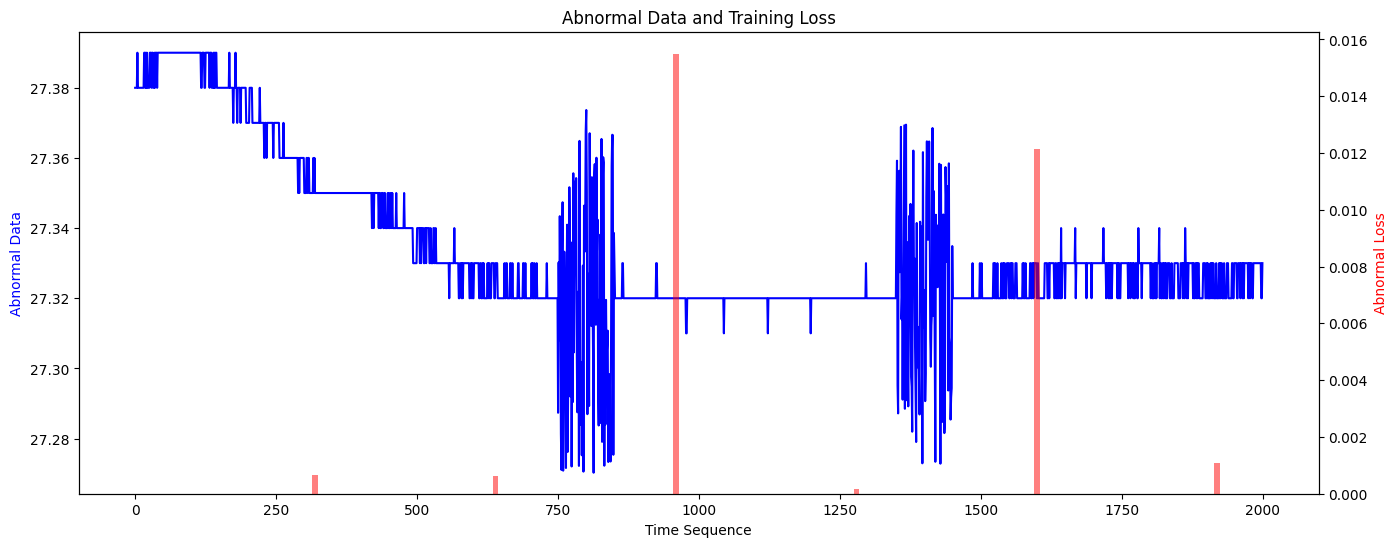

In [7]:
fig, ax1 = plt.subplots(figsize=(16, 6))
ax1.plot(range(len(abnormal_data)), abnormal_data, 'b')
ax1.set_xlabel('Time Sequence')
ax1.set_ylabel('Abnormal Data', color='b')
ax2 = ax1.twinx()
ax2.bar(np.arange(batch_size * sequence_length - 1, batch_size * sequence_length * len(abnormal_loss_cpu), batch_size * sequence_length), abnormal_loss_cpu, width=10, align='center', color='r', alpha=0.5)
ax2.set_ylabel('Abnormal Loss', color='r')
plt.title('Abnormal Data and Training Loss')
plt.show()

# plt.figure(figsize=(16, 6))
# plt.plot(range(len(abnormal_loss_cpu)), abnormal_loss_cpu, 'r')
# plt.xlabel('Sequence')
# plt.ylabel('Loss')
# plt.title('Training Loss')
# plt.show()

In [8]:
print(model)

LSTM_Autoencoder(
  (encoder): Encoder(
    (encoder1): LSTM(1, 128, batch_first=True)
    (encoder2): LSTM(128, 64, batch_first=True)
  )
  (decoder): Decoder(
    (decoder1): LSTM(64, 64, batch_first=True)
    (decoder2): LSTM(64, 128, batch_first=True)
    (timedistributed): TimeDistributed(
      (module): Linear(in_features=128, out_features=1, bias=True)
    )
  )
)
